# Train With Custom Loop

## Define Custom Functions for Training

In [5]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset

class TranslationDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, prefix):
        self.inputs = [prefix + inp for inp in inputs]
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        source = self.tokenizer(self.inputs[idx], return_tensors="pt", padding="max_length", truncation=True)
        target = self.tokenizer(self.targets[idx], return_tensors="pt", padding="max_length", truncation=True)
        return source.input_ids.squeeze(0), source.attention_mask.squeeze(0), target.input_ids.squeeze(0)

In [2]:
def generate_translations(model, tokenizer, source_texts, prefix="Translate Tibetan to English: "):
    model.eval()
    generated_translations = []
    for text in source_texts:
        input_ids = tokenizer(prefix + text, return_tensors="pt", padding="max_length", truncation=True).input_ids.to(model.device)
        output_ids = model.generate(input_ids)
        generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        generated_translations.append(generated_text)
    return generated_translations

## Define Metrics

In [48]:
import sacrebleu
import numpy as np

def calculate_metrics(preds, references, task):
    """
    Calculate BLEU and ChrF scores for the generated translations.
    :param generated: List of generated translations
    :param references: List of reference translations (gold standard)
    """

    # SacreBLEU expects reference translations to be a list of lists
    bleu = sacrebleu.corpus_bleu(preds, [references])
    chrf = sacrebleu.corpus_chrf(preds, [references])
    ter = sacrebleu.corpus_ter(preds, [references])
    

    metrics = {
        f"{task}_BLEU": round(bleu.score,3),
        f"{task}_ChrF" : round(chrf.score,3),
        f"{task}_TER": round(ter.score,3)
    }

    return metrics

## Load Data and Model for Training

In [46]:
from datasets import load_dataset

ds = load_dataset('billingsmoore/LotsawaHouse-bo-en', split='train').select(range(10))
ds = ds.train_test_split(.1)

# Load model and tokenizer
model_name = "google-t5/t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# training data
source_sentences = ds['train']['bo']
target_sentences = ds['train']['en']

# eval data
eval_sources = ds['test']['bo']
eval_targets = ds['test']['en']

## Train on Combined Translation and Post Edit Datasets

In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
batch_size=4
epochs=10

metrics = {}

for epoch in range(epochs):

    if epoch == 0:
        # Initial training for translation
        translation_dataset = TranslationDataset(source_sentences, target_sentences, tokenizer, "Translate Tibetan to English: ")
        dataloader = DataLoader(translation_dataset, batch_size=batch_size, shuffle=True)

        # Train model for one epoch
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            labels[labels == tokenizer.pad_token_id] = -100  # Ignore padding in loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Generate translations for post-edit training
        generated_translations = generate_translations(model, tokenizer, source_sentences)
        post_edit_dataset = TranslationDataset(generated_translations, target_sentences, tokenizer, "Post-Edit: ")

        # Calculate eval metrics
        eval_translations = generate_translations(model, tokenizer, eval_sources)
        metrics[f'Epoch {epoch+1}'] = calculate_metrics(eval_translations, target_sentences, 'translation') | {'post-edit_BLEU': 0, 'post-edit_ChrF': 0, 'post-edit_TER': 100}
        metrics[f'Epoch {epoch+1}']['training_loss'] = round(loss.item(),3)
        print(f'Epoch {epoch+1}: {metrics[f'Epoch {epoch+1}']}')

        
    else:
        # Combine datasets for training
        combined_inputs = translation_dataset.inputs + post_edit_dataset.inputs
        combined_targets = translation_dataset.targets + post_edit_dataset.targets
        combined_dataset = TranslationDataset(combined_inputs, combined_targets, tokenizer, "")

        dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)


        # Train model for one epoch
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            labels[labels == tokenizer.pad_token_id] = -100  # Ignore padding in loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Generate updated translations for post-editing
        generated_translations = generate_translations(model, tokenizer, source_sentences)
        post_edit_dataset = TranslationDataset(generated_translations, target_sentences, tokenizer, "Post-Edit: ")


        # Calculate training metrics
        eval_translations = generate_translations(model, tokenizer, eval_sources)
        eval_post_edits = generate_translations(model, tokenizer, eval_translations, "Post-edit:")
        metrics[f'Epoch {epoch+1}'] = calculate_metrics(eval_translations, eval_targets, 'translation') | calculate_metrics(eval_post_edits, eval_targets, 'post-edit')
        metrics[f'Epoch {epoch+1}']['training_loss'] = round(loss.item(),3)
        print(f'Epoch {epoch+1}: {metrics[f'Epoch {epoch+1}']}')

/home/j/Documents/MLotsawa/.venv/lib/python3.12/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'translation_BLEU': 0.0, 'translation_ChrF': 0.0, 'translation_TER': 100.0}
Epoch 1: {'translation_BLEU': 0.0, 'translation_ChrF': 0.0, 'translation_TER': 100.0, 'post-edit_BLEU': 0, 'post-edit_ChrF': 0, 'post-edit_TER': 100, 'training_loss': 5.872}
{'translation_BLEU': 0.0, 'translation_ChrF': 0.0, 'translation_TER': 100.0}
{'post-edit_BLEU': 0.0, 'post-edit_ChrF': 0.0, 'post-edit_TER': 100.0}
Epoch 2: {'translation_BLEU': 0.0, 'translation_ChrF': 0.0, 'translation_TER': 100.0, 'post-edit_BLEU': 0.0, 'post-edit_ChrF': 0.0, 'post-edit_TER': 100.0, 'training_loss': 5.483}
{'translation_BLEU': 0.0, 'translation_ChrF': 6.078, 'translation_TER': 100.0}
{'post-edit_BLEU': 0.0, 'post-edit_ChrF': 0.0, 'post-edit_TER': 100.0}
Epoch 3: {'translation_BLEU': 0.0, 'translation_ChrF': 6.078, 'translation_TER': 100.0, 'post-edit_BLEU': 0.0, 'post-edit_ChrF': 0.0, 'post-edit_TER': 100.0, 'training_loss': 3.649}
{'translation_BLEU': 4.196, 'translation_ChrF': 9.459, 'translation_TER': 112.5}
{'post-e

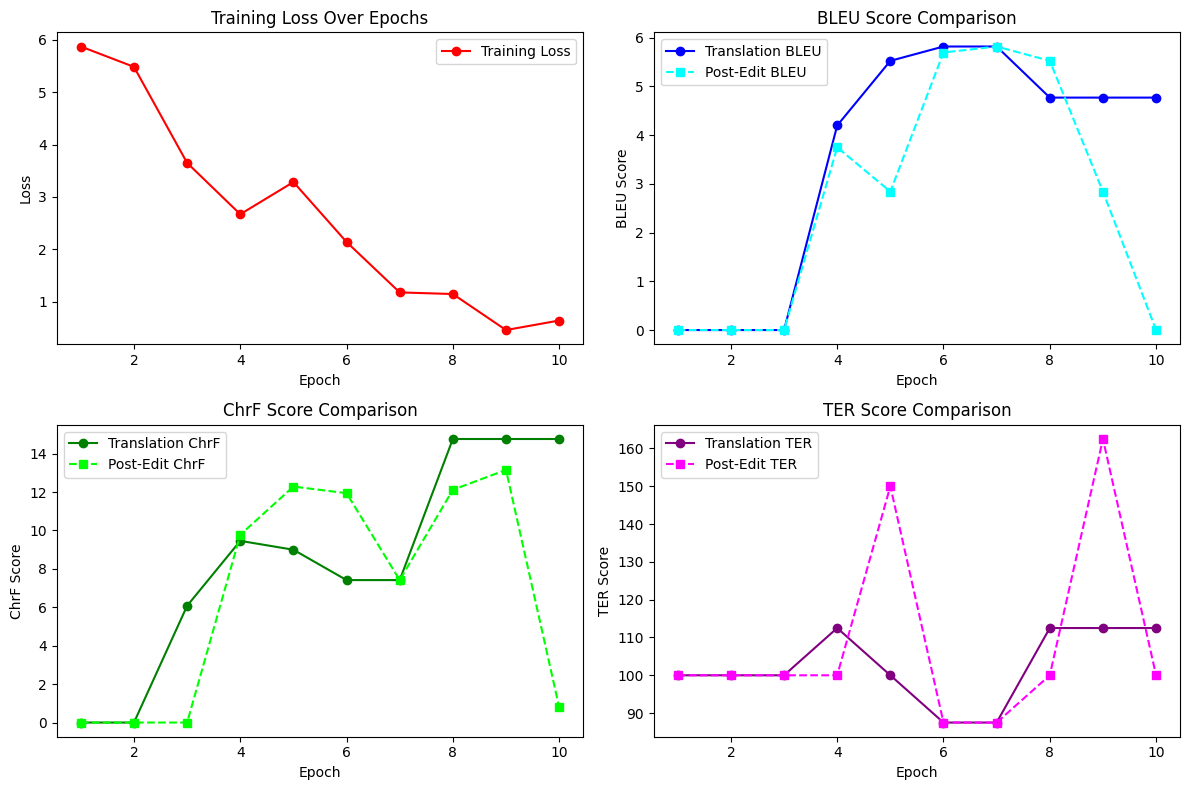

In [49]:
import matplotlib.pyplot as plt

# Extract epochs
epochs = list(metrics.keys())

# Extract metric values
training_loss = [metrics[epoch]["training_loss"] for epoch in epochs]

translation_BLEU = [metrics[epoch]["translation_BLEU"] for epoch in epochs]
post_edit_BLEU = [metrics[epoch].get("post-edit_BLEU", None) for epoch in epochs]

translation_ChrF = [metrics[epoch]["translation_ChrF"] for epoch in epochs]
post_edit_ChrF = [metrics[epoch].get("post-edit_ChrF", None) for epoch in epochs]

translation_TER = [metrics[epoch]["translation_TER"] for epoch in epochs]
post_edit_TER = [metrics[epoch].get("post-edit_TER", None) for epoch in epochs]

# Convert None values to avoid plotting errors
post_edit_BLEU = [x if x is not None else 0 for x in post_edit_BLEU]
post_edit_ChrF = [x if x is not None else 0 for x in post_edit_ChrF]
post_edit_TER = [x if x is not None else 0 for x in post_edit_TER]

# Switch epochs to just be numbers

epochs = range(1,len(epochs)+1)

# Create plots
plt.figure(figsize=(12, 8))

# Plot Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, training_loss, marker='o', linestyle='-', color='r', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Plot BLEU Scores
plt.subplot(2, 2, 2)
plt.plot(epochs, translation_BLEU, marker='o', linestyle='-', label="Translation BLEU", color="blue")
plt.plot(epochs, post_edit_BLEU, marker='s', linestyle='--', label="Post-Edit BLEU", color="cyan")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison")
plt.legend()

# Plot ChrF Scores
plt.subplot(2, 2, 3)
plt.plot(epochs, translation_ChrF, marker='o', linestyle='-', label="Translation ChrF", color="green")
plt.plot(epochs, post_edit_ChrF, marker='s', linestyle='--', label="Post-Edit ChrF", color="lime")
plt.xlabel("Epoch")
plt.ylabel("ChrF Score")
plt.title("ChrF Score Comparison")
plt.legend()

# Plot TER Scores
plt.subplot(2, 2, 4)
plt.plot(epochs, translation_TER, marker='o', linestyle='-', label="Translation TER", color="purple")
plt.plot(epochs, post_edit_TER, marker='s', linestyle='--', label="Post-Edit TER", color="magenta")
plt.xlabel("Epoch")
plt.ylabel("TER Score")
plt.title("TER Score Comparison")
plt.legend()

plt.tight_layout()
plt.show()
